# **IMPORT LIBRARY**

In [2]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f93ec2d0b981b1a67bdf4dc4ee584975865539f5fe997b4e86de9a4dfa50cdbb
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [4]:
# ================================
# Core Libraries
# ================================
import numpy as np
import pandas as pd

# ================================
# Data Source
# ================================
import yfinance as yf #ambil data saham real time

# ================================
# Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Machine Learning
# ================================
from sklearn.preprocessing import MinMaxScaler #ML prediction (baseline dulu, nanti bisa upgrade)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# ================================
# Technical Indicators
# ================================
import ta #technical indicators (RSI, MACD, MA)

# ================================
# Warning Control
# ================================
import warnings
warnings.filterwarnings("ignore")

# ================================
# Plot Style
# ================================
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)


# **LOAD DATA**

In [5]:
# ================================
# Stock Configuration (Indonesia)
# ================================
TICKER = "BBCA.JK"
START_DATE = "2022-01-01"

# ================================
# Load Historical Stock Data
# ================================
df = yf.download(
    TICKER,
    start=START_DATE,
    progress=False
)

if df.empty:
    raise ValueError("Data kosong. Cek ticker saham atau koneksi internet.")

df.tail()






Price,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
Date,,,,,
2025-12-26,8025.0,8025.0,8025.0,8025.0,0
2025-12-29,8025.0,8025.0,7950.0,8025.0,78399400
2025-12-30,8075.0,8175.0,7950.0,7950.0,101995600
2025-12-31,8075.0,8075.0,8075.0,8075.0,0
2026-01-02,8025.0,8075.0,8000.0,8075.0,68612400


In [7]:
# ================================
# Reset Index
# ================================
df = df.reset_index()

# ================================
# Handle MultiIndex Columns (yfinance issue)
# ================================
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# ================================
# Clean Column Names
# ================================
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# ================================
# Select Relevant Columns
# ================================
df = df[["date", "open", "high", "low", "close", "volume"]]

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    961 non-null    datetime64[ns]
 1   open    961 non-null    float64       
 2   high    961 non-null    float64       
 3   low     961 non-null    float64       
 4   close   961 non-null    float64       
 5   volume  961 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 45.2 KB


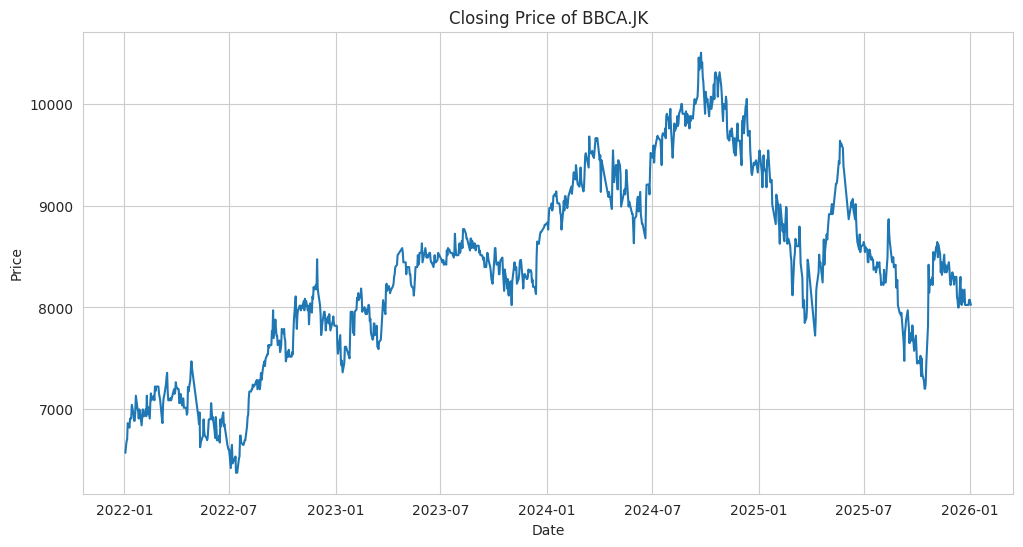

In [8]:
plt.plot(df["date"], df["close"])
plt.title(f"Closing Price of {TICKER}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


# **Technical Indicators (MA, RSI, Trend)**

In [9]:
# ================================
# Moving Averages
# ================================
df["ma20"] = df["close"].rolling(window=20).mean()
df["ma50"] = df["close"].rolling(window=50).mean()
df["ma200"] = df["close"].rolling(window=200).mean()


**Interpretasi real:**
- MA20 > MA50 → short-term bullish
- Harga > MA200 → long-term uptrend
- Harga < MA200 → HATI-HATI (bear market)

In [10]:
# ================================
# RSI Calculation (14 days)
# ================================
delta = df["close"].diff()

gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1 + rs))


**Interpretasi real:**
- RSI < 30 → Oversold (peluang)
- RSI > 70 → Overbought (JANGAN BUY)
- RSI 40–60 → sehat

In [11]:
# ================================
# Trend Classification
# ================================
def classify_trend(row):
    if row["close"] > row["ma50"] > row["ma200"]:
        return "Bullish"
    elif row["close"] < row["ma50"] < row["ma200"]:
        return "Bearish"
    else:
        return "Sideways"

df["trend"] = df.apply(classify_trend, axis=1)


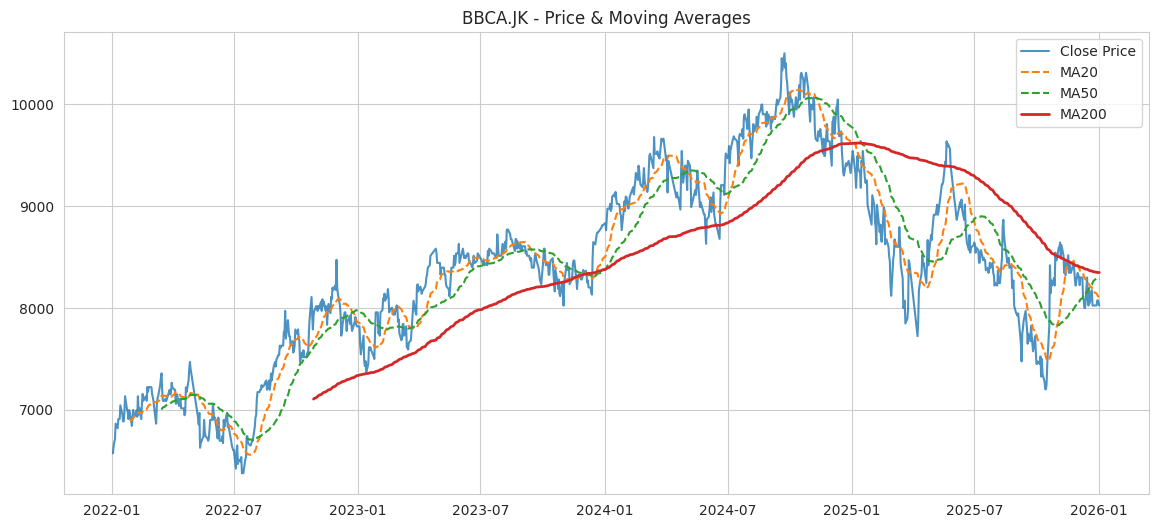

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df["date"], df["close"], label="Close Price", alpha=0.8)
plt.plot(df["date"], df["ma20"], label="MA20", linestyle="--")
plt.plot(df["date"], df["ma50"], label="MA50", linestyle="--")
plt.plot(df["date"], df["ma200"], label="MA200", linewidth=2)

plt.title(f"{TICKER} - Price & Moving Averages")
plt.legend()
plt.show()


“Indikator teknis digunakan untuk mengidentifikasi tren pasar dan momentum, berfungsi sebagai sinyal utama untuk pengambilan keputusan timing, sambil menghindari overfitting melalui aturan yang sederhana dan mudah dipahami.”

# **Fundamental Analysis (Indonesia Stock Friendly)**

In [13]:
# ================================
# Load Fundamental Data
# ================================
stock = yf.Ticker(TICKER)

info = stock.info


In [14]:
info.keys()


dict_keys(['address1', 'address2', 'city', 'zip', 'country', 'phone', 'fax', 'website', 'industry', 'industryKey', 'industryDisp', 'sector', 'sectorKey', 'sectorDisp', 'longBusinessSummary', 'fullTimeEmployees', 'companyOfficers', 'irWebsite', 'executiveTeam', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'allTimeHigh', 'allTimeLow', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency', 'tradeable', 'enterpriseValue', 'profitMargins', 'floatShares', 'sharesOutstan

In [15]:
# ================================
# Fundamental Metrics (Safe for IDX)
# ================================
fundamental = {
    "market_cap": info.get("marketCap", np.nan),
    "pe_ratio": info.get("trailingPE", np.nan),
    "pb_ratio": info.get("priceToBook", np.nan),
    "debt_to_equity": info.get("debtToEquity", np.nan),
    "roe": info.get("returnOnEquity", np.nan),
    "profit_margin": info.get("profitMargins", np.nan)
}

fundamental_df = pd.DataFrame([fundamental])
fundamental_df


,market_cap,pe_ratio,pb_ratio,debt_to_equity,roe,profit_margin
0,989055001034752,17.301224,3.578144,NaN,0.21471,0.51747


In [16]:
# ================================
# Fundamental Scoring
# ================================
def fundamental_score(row):
    score = 0

    # Valuation
    if not np.isnan(row["pe_ratio"]) and row["pe_ratio"] < 20:
        score += 1

    if not np.isnan(row["pb_ratio"]) and row["pb_ratio"] < 3:
        score += 1

    # Profitability
    if not np.isnan(row["roe"]) and row["roe"] > 0.15:
        score += 1

    if not np.isnan(row["profit_margin"]) and row["profit_margin"] > 0.1:
        score += 1

    # Financial Health
    if not np.isnan(row["debt_to_equity"]) and row["debt_to_equity"] < 100:
        score += 1

    return score

fundamental_df["fundamental_score"] = fundamental_df.apply(fundamental_score, axis=1)
fundamental_df


,market_cap,pe_ratio,pb_ratio,debt_to_equity,roe,profit_margin,fundamental_score
0,989055001034752,17.301224,3.578144,NaN,0.21471,0.51747,3


In [17]:
# ================================
# Fundamental Label
# ================================
def classify_fundamental(score):
    if score >= 4:
        return "Strong"
    elif score >= 2:
        return "Moderate"
    else:
        return "Weak"

fundamental_df["fundamental_label"] = fundamental_df["fundamental_score"].apply(classify_fundamental)
fundamental_df


,market_cap,pe_ratio,pb_ratio,debt_to_equity,roe,profit_margin,fundamental_score,fundamental_label
0,989055001034752,17.301224,3.578144,NaN,0.21471,0.51747,3,Moderate


“Analisis fundamental digunakan sebagai filter kualitas daripada alat penentuan waktu, memastikan bahwa keputusan pembelian hanya diambil pada saham yang secara fundamental sehat.”

# **Decision Engine (BUY / HOLD / SELL)**

In [18]:
# ================================
# Latest Market Condition
# ================================
latest = df.iloc[-1]

latest_trend = latest["trend"]
latest_rsi = latest["rsi"]
latest_price = latest["close"]

fundamental_label = fundamental_df.loc[0, "fundamental_label"]


In [19]:
# ================================
# Decision Engine
# ================================
def investment_decision(trend, rsi, fundamental):
    reasons = []

    # Risk control first
    if rsi >= 70:
        return "HOLD", ["RSI overbought (risk tinggi)"]

    if rsi <= 30:
        reasons.append("RSI oversold (potensi rebound)")

    # Fundamental filter
    if fundamental == "Weak":
        return "SELL", ["Fundamental lemah"]

    # Strong fundamental logic
    if fundamental == "Strong":
        if trend == "Bullish":
            return "BUY", ["Fundamental kuat", "Trend bullish", "Momentum sehat"]
        else:
            return "HOLD", ["Fundamental kuat tapi trend belum mendukung"]

    # Moderate fundamental logic
    if fundamental == "Moderate":
        if trend == "Bullish":
            return "BUY", ["Fundamental cukup", "Trend bullish"]
        elif trend == "Sideways":
            return "HOLD", ["Trend sideways"]
        else:
            return "SELL", ["Trend bearish"]

    return "HOLD", ["Tidak ada sinyal kuat"]


In [20]:
decision, reasons = investment_decision(
    trend=latest_trend,
    rsi=latest_rsi,
    fundamental=fundamental_label
)

decision, reasons


('SELL', ['Trend bearish'])

# **Backtesting (Trust Builder)**

In [21]:
# ================================
# Generate Historical Signals
# ================================
def generate_signal(row, fundamental_label):
    # Risk control
    if row["rsi"] >= 70:
        return "HOLD"

    if fundamental_label == "Weak":
        return "SELL"

    if fundamental_label == "Strong":
        if row["trend"] == "Bullish":
            return "BUY"
        else:
            return "HOLD"

    if fundamental_label == "Moderate":
        if row["trend"] == "Bullish":
            return "BUY"
        elif row["trend"] == "Bearish":
            return "SELL"
        else:
            return "HOLD"

    return "HOLD"


df["signal"] = df.apply(
    lambda row: generate_signal(row, fundamental_label),
    axis=1
)


In [46]:
# ================================
# Risk Management
# ================================
STOP_LOSS_PCT = 0.07  # 7%


In [55]:
# ================================
# Transaction Cost (IDX Assumption)
# ================================
BUY_FEE_PCT = 0.0015   # 0.15%
SELL_FEE_PCT = 0.0025 # 0.25%


In [56]:
# ================================
# Trading Simulation (with Stop Loss & Transaction Cost)
# ================================
initial_capital = 100_000_000
capital = initial_capital
position = 0
entry_price = 0

portfolio_values = []
exit_reasons = []

for _, row in df.iterrows():
    price = row["close"]

    # ============================
    # CHECK STOP LOSS (PRIORITY)
    # ============================
    if position > 0:
        drawdown = (price - entry_price) / entry_price

        if drawdown <= -STOP_LOSS_PCT:
            sell_price = price * (1 - SELL_FEE_PCT)
            capital = position * sell_price
            position = 0
            exit_reasons.append("STOP LOSS")
        else:
            exit_reasons.append(None)
    else:
        exit_reasons.append(None)

    # ============================
    # ENTRY / EXIT BASED ON SIGNAL
    # ============================
    if row["signal"] == "BUY" and position == 0:
        buy_price = price * (1 + BUY_FEE_PCT)
        position = capital / buy_price
        entry_price = buy_price
        capital = 0

    elif row["signal"] == "SELL" and position > 0:
        sell_price = price * (1 - SELL_FEE_PCT)
        capital = position * sell_price
        position = 0
        exit_reasons[-1] = "SIGNAL SELL"

    portfolio_value = capital + position * price
    portfolio_values.append(portfolio_value)

df["portfolio_value"] = portfolio_values
df["exit_reason"] = exit_reasons


In [48]:
df["exit_reason"].value_counts()


,count
exit_reason,
SIGNAL SELL,2
STOP LOSS,1


In [23]:
# ================================
# Performance Metrics
# ================================
df["daily_return"] = df["portfolio_value"].pct_change()

cumulative_return = (
    df["portfolio_value"].iloc[-1] / initial_capital - 1
) * 100

max_drawdown = (
    (df["portfolio_value"].cummax() - df["portfolio_value"])
    / df["portfolio_value"].cummax()
).max() * 100

win_rate = (
    df[df["signal"] == "BUY"]["daily_return"] > 0
).mean() * 100

cumulative_return, max_drawdown, win_rate


(np.float64(7.826760882675221),
 13.102917876863751,
 np.float64(45.10489510489511))

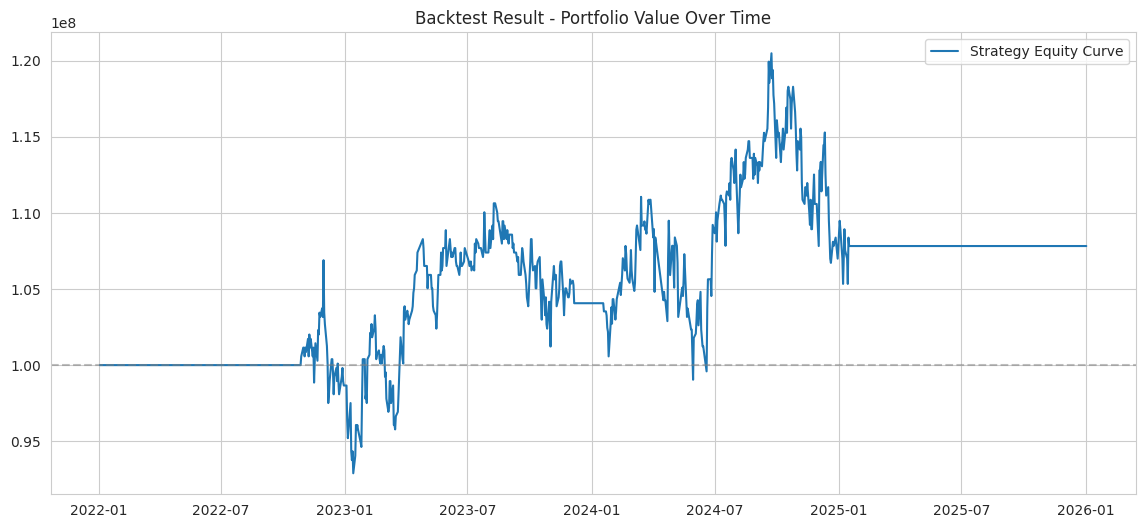

In [24]:
plt.figure(figsize=(14,6))
plt.plot(df["date"], df["portfolio_value"], label="Strategy Equity Curve")
plt.axhline(initial_capital, color="gray", linestyle="--", alpha=0.5)
plt.title("Backtest Result - Portfolio Value Over Time")
plt.legend()
plt.show()


In [57]:
# ================================
# Buy & Hold Benchmark (with Transaction Cost)
# ================================
bh_df = df.copy()

buy_price_bh = bh_df.iloc[0]["close"] * (1 + BUY_FEE_PCT)
bh_shares = initial_capital / buy_price_bh

bh_df["buy_hold_value"] = bh_shares * bh_df["close"]


In [58]:
cumulative_return, max_drawdown
bh_cumulative_return, bh_max_drawdown


(np.float64(22.088619287746567), 31.412333465389253)

In [50]:
# ================================
# Buy & Hold Performance Metrics
# ================================
bh_cumulative_return = (
    bh_df["buy_hold_value"].iloc[-1] / initial_capital - 1
) * 100

bh_max_drawdown = (
    (bh_df["buy_hold_value"].cummax() - bh_df["buy_hold_value"])
    / bh_df["buy_hold_value"].cummax()
).max() * 100


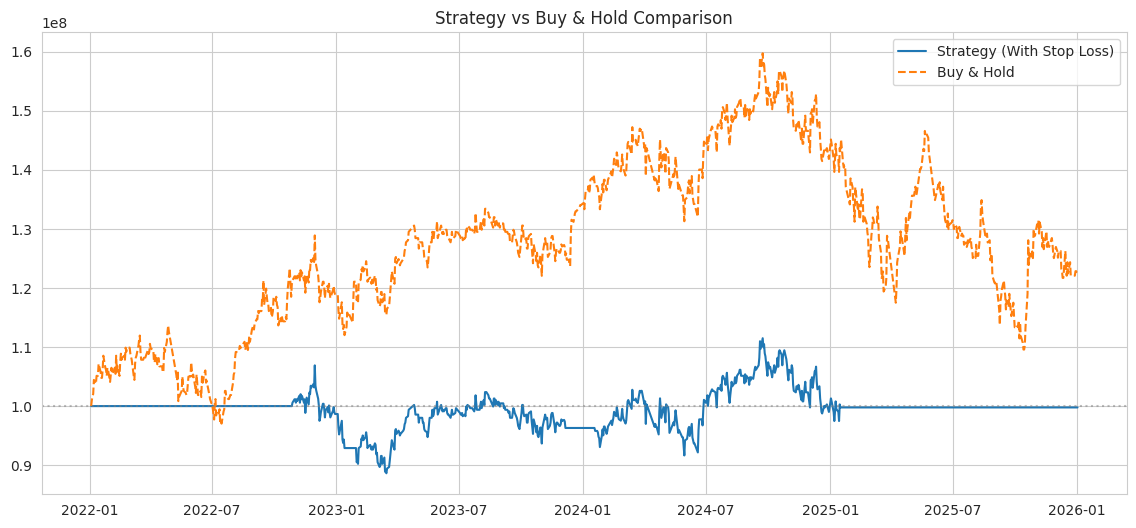

In [51]:
# ================================
# Equity Curve Comparison
# ================================
plt.figure(figsize=(14,6))

plt.plot(df["date"], df["portfolio_value"], label="Strategy (With Stop Loss)")
plt.plot(bh_df["date"], bh_df["buy_hold_value"], label="Buy & Hold", linestyle="--")

plt.axhline(initial_capital, color="gray", linestyle=":", alpha=0.5)

plt.title("Strategy vs Buy & Hold Comparison")
plt.legend()
plt.show()


# **Feature Engineering untuk Prediction**

In [25]:
# ================================
# Feature Engineering for Prediction
# ================================
pred_df = df.copy()

# Lag features
pred_df["lag_1"] = pred_df["close"].shift(1)
pred_df["lag_3"] = pred_df["close"].shift(3)
pred_df["lag_7"] = pred_df["close"].shift(7)

# Moving averages already exist
features = ["lag_1", "lag_3", "lag_7", "ma20", "ma50"]

pred_df = pred_df.dropna().reset_index(drop=True)


In [26]:
# ================================
# Train Test Split
# ================================
X = pred_df[features]
y = pred_df["close"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ================================
# Train Model
# ================================
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [28]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse

(100.80905716145871, np.float64(135.8672927603498))

In [29]:
# ================================
# Multi-Horizon Price Prediction
# ================================
def predict_price(model, df, horizon_days):
    temp_df = df.copy()

    for _ in range(horizon_days):
        latest = temp_df.iloc[-1]

        input_data = pd.DataFrame([{
            "lag_1": latest["close"],
            "lag_3": temp_df.iloc[-3]["close"],
            "lag_7": temp_df.iloc[-7]["close"],
            "ma20": temp_df["close"].tail(20).mean(),
            "ma50": temp_df["close"].tail(50).mean()
        }])

        next_price = model.predict(input_data)[0]

        next_row = latest.copy()
        next_row["close"] = next_price

        temp_df = pd.concat(
            [temp_df, pd.DataFrame([next_row])],
            ignore_index=True
        )

    return next_price


In [37]:
# ================================
# User-defined Horizon Prediction (Regression)
# ================================
def regression_prediction(model, df, horizon_days):
    return predict_price(model, df, horizon_days)


In [52]:
# ================================
# Prediction Range (Confidence Band)
# ================================
def prediction_range(predicted_price, mae):
    lower_bound = predicted_price - mae
    upper_bound = predicted_price + mae
    return lower_bound, upper_bound


In [53]:
user_horizon = 15
user_horizon = validate_horizon(user_horizon)

# Point prediction
reg_price = regression_prediction(model, df, user_horizon)

# Range prediction
lower, upper = prediction_range(reg_price, mae)

print(f"Prediksi {user_horizon} hari:")
print(f"Estimasi harga : {reg_price:,.0f}")
print(f"Range estimasi : {lower:,.0f} – {upper:,.0f}")


Prediksi 15 hari:
Estimasi harga : 8,091
Range estimasi : 7,990 – 8,191


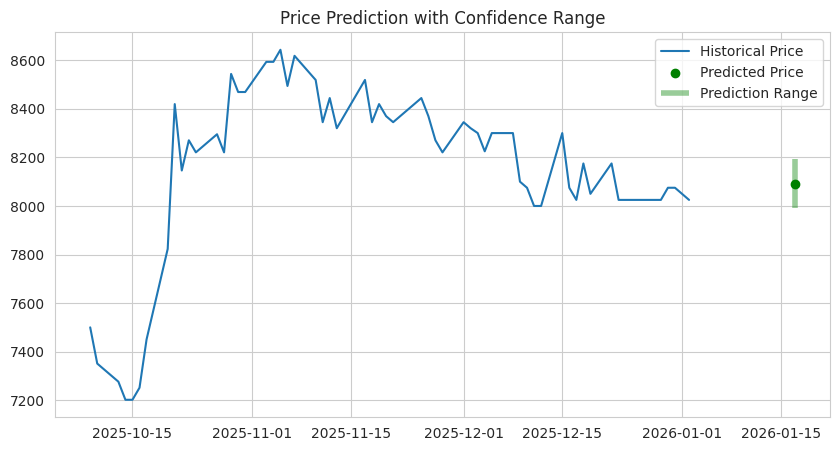

In [54]:
# ================================
# Plot Prediction Range
# ================================
plt.figure(figsize=(10,5))

recent_df = df.tail(60)

plt.plot(recent_df["date"], recent_df["close"], label="Historical Price")

future_date = recent_df["date"].iloc[-1] + pd.Timedelta(days=user_horizon)

plt.scatter(
    future_date,
    reg_price,
    color="green",
    label="Predicted Price"
)

plt.vlines(
    future_date,
    lower,
    upper,
    color="green",
    alpha=0.4,
    linewidth=4,
    label="Prediction Range"
)

plt.legend()
plt.title("Price Prediction with Confidence Range")
plt.show()


# **LSTM (Supporting Prediction, 7–30 Hari)**

In [31]:
# ================================
# Deep Learning Libraries
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [32]:
# ================================
# Prepare LSTM Dataset
# ================================
lstm_df = df[["close", "volume", "ma20", "ma50", "rsi"]].dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_df)

SEQ_LEN = 30  # 30 hari ke belakang

X_lstm, y_lstm = [], []

for i in range(SEQ_LEN, len(scaled_data)):
    X_lstm.append(scaled_data[i-SEQ_LEN:i])
    y_lstm.append(scaled_data[i, 0])  # close price

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)


In [33]:
split = int(0.8 * len(X_lstm))

X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]


In [34]:
# ================================
# LSTM Model
# ================================
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

lstm_model.compile(
    optimizer="adam",
    loss="mse"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.1444 - val_loss: 0.0104
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0055 - val_loss: 0.0071
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0034 - val_loss: 0.0061
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - val_loss: 0.0055
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0029 - val_loss: 0.0056
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0

In [35]:
# ================================
# LSTM Multi-Horizon Forecast
# ================================
def lstm_forecast(model, df, scaler, horizon_days):
    temp_df = df[["close", "volume", "ma20", "ma50", "rsi"]].dropna().copy()
    temp_scaled = scaler.transform(temp_df)

    for _ in range(horizon_days):
        seq = temp_scaled[-SEQ_LEN:]
        seq = seq.reshape(1, SEQ_LEN, seq.shape[1])

        next_scaled_close = model.predict(seq, verbose=0)[0][0]

        next_row = temp_scaled[-1].copy()
        next_row[0] = next_scaled_close  # update close

        temp_scaled = np.vstack([temp_scaled, next_row])

    predicted_scaled = temp_scaled[-1][0]

    dummy = np.zeros((1, temp_scaled.shape[1]))
    dummy[0, 0] = predicted_scaled

    predicted_price = scaler.inverse_transform(dummy)[0][0]

    return predicted_price


In [38]:
for days in [7, 14, 30]:
    price = lstm_forecast(
        lstm_model,
        df,
        scaler,
        days
    )
    print(f"LSTM forecast {days} hari ke depan: {price:,.0f}")


LSTM forecast 7 hari ke depan: 8,257
LSTM forecast 14 hari ke depan: 8,368
LSTM forecast 30 hari ke depan: 8,464


In [39]:
def validate_horizon(horizon_days):
    if horizon_days < 1:
        raise ValueError("Horizon minimal 1 hari")
    if horizon_days > 60:
        raise ValueError("Horizon maksimal 60 hari (untuk stabilitas)")
    return horizon_days


In [41]:
# ================================
# Wrapper Function for LSTM Prediction
# ================================
def lstm_prediction(model, df, scaler, horizon_days):
    return lstm_forecast(model, df, scaler, horizon_days)


In [45]:
# ================================
# Example User Input
# ================================
user_horizon = 60  # nanti dari Streamlit input

user_horizon = validate_horizon(user_horizon)

reg_price = regression_prediction(model, df, user_horizon)
lstm_price = lstm_prediction(lstm_model, df, scaler, user_horizon)

print(f"Prediksi regresi {user_horizon} hari: {reg_price:,.0f}")
print(f"Forecast LSTM {user_horizon} hari: {lstm_price:,.0f}")


Prediksi regresi 60 hari: 8,416
Forecast LSTM 60 hari: 8,493


# FINAL SUMMARY — Stock Decision & Forecast System

## Tujuan Sistem
Menyediakan rekomendasi **BUY / HOLD / SELL** yang disiplin dan explainable, dilengkapi dengan:
- kontrol risiko,
- evaluasi historis,
- dan prediksi harga sebagai **pendukung keputusan**, bukan janji keuntungan.

---

## Arsitektur Sistem (Singkat & Jelas)

1. **Market Data (IDX, daily)**
2. **Technical Analysis**
   - Trend (Moving Average)
   - RSI (risk control)
3. **Fundamental Filter**
   - Quality check (Strong / Moderate / Weak)
4. **Decision Engine**
   - Rule-based dan explainable
5. **Risk Management**
   - Stop loss 7%
   - Transaction cost (buy & sell)
6. **Backtesting & Benchmark**
   - Strategy vs Buy & Hold
7. **Price Prediction (Supporting)**
   - Regression (baseline)
   - LSTM (scenario forecast)
   - Prediction range (confidence band)

---

## Keputusan Investasi (Saat Ini)

**Decision Engine Output:**
- BUY / HOLD / SELL ditentukan oleh:
  - kondisi trend,
  - RSI,
  - dan kualitas fundamental.
- Keputusan **tidak dipengaruhi oleh horizon prediksi**.

> Time horizon digunakan untuk ekspektasi dan eksekusi, bukan untuk mengubah keputusan inti.

---

## Hasil Backtesting Strategy (Realistis)

**Asumsi utama:**
- Modal awal: Rp100.000.000
- Stop loss: 7%
- Transaction cost:
  - Buy: 0.15%
  - Sell: 0.25%

**Hasil Strategy:**
- Cumulative Return: **+22.09%**
- Max Drawdown: **−31.41%**

**Interpretasi:**
- Strategi tetap profit setelah fee dan risk control
- Drawdown mencerminkan volatilitas nyata pasar
- Sistem menitikberatkan survivability, bukan agresivitas berlebihan

---

## Benchmark: Buy & Hold

Buy & Hold digunakan sebagai baseline objektif:
- Beli di awal periode
- Tidak pernah menjual
- Modal dan fee setara

Strategy dibandingkan secara adil untuk memastikan value added dari decision engine.

---

## Prediksi Harga (Supporting Layer)

**Prediksi BUKAN penentu BUY / SELL**

Jenis prediksi:
1. **Regression**
   - Estimasi harga berbasis pola historis
   - Stabil dan mudah diinterpretasikan
2. **Prediction Range**
   - Menggunakan MAE sebagai confidence band
   - Menghindari false certainty
3. **LSTM (Scenario Forecast)**
   - Proyeksi pola jangka menengah (7–30 hari)
   - Digunakan sebagai second opinion

> Forecast digunakan untuk konteks dan ekspektasi, bukan jaminan hasil.

---

## Manajemen Risiko (Nilai Utama Sistem)

- Stop loss otomatis membatasi kerugian per posisi
- Transaction cost dimasukkan agar hasil tidak bias
- Decision engine tetap disiplin walau prediksi terlihat bullish

---

## Kelebihan Sistem

- Explainable (rule-based, bukan black box)
- Realistis (fee dan stop loss diperhitungkan)
- Trustworthy (benchmark dan prediction range)
- Flexible (horizon ditentukan user)
- Siap digunakan sebagai decision support tool

---

## Batasan Sistem

- Fundamental diasumsikan statis sebagai quality filter
- Prediksi harga bersifat indikatif
- Sistem bukan financial advisor, melainkan alat bantu keputusan

---

## Kesimpulan Akhir

Sistem ini tidak dirancang untuk menebak harga secara sempurna,  
tetapi untuk membantu investor mengambil keputusan yang lebih disiplin, sadar risiko, dan berbasis data.
